In [23]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [24]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
from matplotlib.pyplot import hist

In [25]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [26]:
x = pd.read_stata("maindata.dta", convert_categoricals=False)
laws_csv = pd.read_csv("When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

In [43]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think
#age_subset = np.logical_and(np.greater_equal(basic_merged["a_age"],18), np.greater_equal(19,basic_merged["a_age"]))
# 17 <= age <= 21 (maybe should be like 22)
#basic_merged = basic_merged[age_subset]
#print(basic_merged.shape)

# Dropping states who were treated < 97 (i.e. they always had programs)
# This is following Callaway + Sant'anna, as we cannot meaningfully 
# do any inference using those states. Although we can compare them later as a 
# robustness check, which may be interesting
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# I also drop the never states, as they may be substantively different from others, although this can be relaxed later.
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to intbasic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("never")==False]  # Only want to look at one for now. 

# As we are treating >19 as the never-treated group, we set their year implemented as 1000000 >> 1999
year_implemented_vector = basic_merged["Year_Implemented"].copy()
year_implemented_vector[basic_merged["under19"] == 0] = 1000000
basic_merged["group"] = year_implemented_vector  # Equals the year you were first treated. If >=19 then treated at t = infty

# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["fownu18", "faminctm1", "a_maritl", "female" , "fpovcut", "povll"]#, "stfips"]
list_of_confounders += ["anykids", "disability", "collgrad", "hsgrad"] # coll + hs are extra for now. 

In [6]:
def make_g_model():
  return RandomForestClassifier(n_estimators=100, max_depth=2)

In [42]:
def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions

In [64]:
#overlap and g scores are calculated as the probabiliy that the indiviual is treated (under 19) in treated year given
#that you were either in that state in 1997 or never treated at all (over age of 19)
def calculate_g(treated_year):
    sub_merged = basic_merged.copy()
    sub_merged = sub_merged[(sub_merged["group"] == treated_year) | (sub_merged["group"] == 1000000)]
    
    treatment_bin = {treated_year: 1, 1000000: 0}
    sub_merged.group = [treatment_bin[item] for item in sub_merged.group]
    sub_merged = sub_merged.reset_index()
    
    treatment = sub_merged["group"]
    confounders = sub_merged[list_of_confounders]
    
    g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)
    
    return g
    

(array([6.27600808, 9.79278123, 5.80357876, 5.30612178, 3.62707546,
        0.17596767, 0.46933312, 0.49397375, 0.93763416, 2.68324889]),
 array([0.0237308 , 0.05184776, 0.07996472, 0.10808168, 0.13619864,
        0.1643156 , 0.19243256, 0.22054952, 0.24866648, 0.27678344,
        0.3049004 ]),
 <a list of 10 Patch objects>)

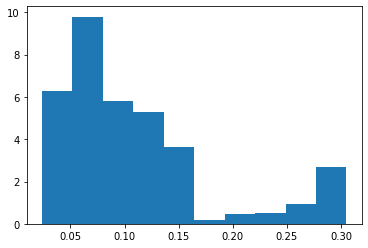

In [65]:
g1 = calculate_g(1997)
hist(g1, density=True)

(array([1.05398117, 2.56193093, 2.42692315, 2.0741609 , 1.33928902,
        1.41248422, 0.81425328, 0.35211889, 0.71161174, 6.4405836 ]),
 array([0.07658112, 0.12869883, 0.18081654, 0.23293425, 0.28505195,
        0.33716966, 0.38928737, 0.44140507, 0.49352278, 0.54564049,
        0.59775819]),
 <a list of 10 Patch objects>)

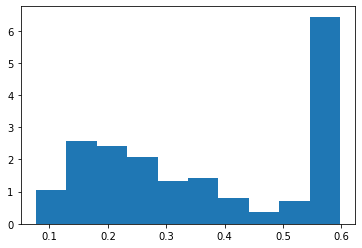

In [66]:
g2 = calculate_g(1998)
hist(g2, density=True)

(array([3.96601886, 6.57517378, 4.14216266, 2.86392725, 2.72555695,
        0.97674323, 1.19344384, 2.55299169, 2.00169737, 2.12396423]),
 array([0.02803978, 0.06237846, 0.09671714, 0.13105582, 0.1653945 ,
        0.19973318, 0.23407185, 0.26841053, 0.30274921, 0.33708789,
        0.37142657]),
 <a list of 10 Patch objects>)

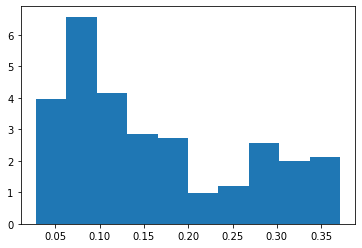

In [67]:
g3 = calculate_g(1999)
hist(g3, density=True)

In [ ]:
def dr_treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int, year_of_interest:int):
    # k-folding
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # group of people 
    G_g_and_C = np.logical_or(np.equal(A,year_of_interest), np.equal(A,1000000))

    # subset for people in G_g or C, then reset index to allow for kfolding
    covariates = X.copy()
    covariates = covariates.loc[G_g_and_C]
    covariates = covariates.reset_index(drop=True)

    treatment_status = (A == year_of_interest)
    treatment_status = treatment_status.loc[G_g_and_C]
    treatment_status = treatment_status.reset_index(drop=True)

    g_matrix = np.full_like(treatment_status, np.nan, dtype=float)

    # Generating vectors which will contain the true treatment/year combination for each covariate. 
    # Normalizing years so that year =1 when treatment first occurs. 
    #covariates.drop("year", axis=1)  # We are interested in the covariates, not the year they were found in. 

    for train_index, test_index in kf.split(covariates, treatment_status):
        X_train = covariates.loc[train_index]
        y_train = treatment_status.loc[train_index]
        g = make_model()
        g.fit(X_train, y_train)
        g_matrix[test_index] = g.predict_proba(covariates.loc[test_index])[:, 1]
    assert np.isnan(g_matrix).sum() == 0  # Sanity check that we have no missings
    print("Max p:" + str(np.max(g_matrix))) # Checking for overlap
    from matplotlib.pyplot import hist
    hist(g_matrix, density=True)
    return g_matrix

In [83]:
def fit_g(treated_year, g_model):
    sub_merged = basic_merged.copy()
    sub_merged = sub_merged[(sub_merged["group"] == treated_year) | (sub_merged["group"] == 1000000)]
    
    treatment_bin = {treated_year: 1, 1000000: 0}
    sub_merged.group = [treatment_bin[item] for item in sub_merged.group]
    sub_merged = sub_merged.reset_index()
    
    treatment = sub_merged["group"]
    confounders = sub_merged[list_of_confounders]
    
    x_train, x_test, a_train, a_test = train_test_split(confounders, treatment, test_size=0.2)
    g_model.fit(x_train, a_train)
    a_pred = g_model.predict_proba(x_test)[:,1]
    
    test_ce=log_loss(a_test, a_pred)
    score = g_model.score(x_test,a_test)
    
    return test_ce, score

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

Rf = RandomForestClassifier(n_estimators=100, max_depth=10)
KNN = KNeighborsClassifier()
LogReg = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
XGBoost = sklearn.ensemble.GradientBoostingClassifier()

models = [Rf, KNN, LogReg, XGBoost]

In [109]:
def fit_year(treated_year, models):
    fit_stat = pd.DataFrame()
    model_lst = ["Rf", "KNN", "LogReg", "XGBoost"]
    g_ce = []
    score = []

    for model in models:
        x, y = fit_g(treated_year, model)
        g_ce.append(x)
        score.append(y)

    fit_stat["model"] = model_lst
    fit_stat["g_ce"] = g_ce
    fit_stat["score"] = score

    return fit_stat

In [110]:
fit_year(1997, models)

,model,g_ce,score
0,Rf,0.194829,0.922502
1,KNN,1.471080,0.879047
2,LogReg,0.383875,0.885485
3,XGBoost,0.193185,0.925894


In [111]:
fit_year(1998, models)

,model,g_ce,score
0,Rf,0.330780,0.858604
1,KNN,1.884345,0.670716
2,LogReg,0.512450,0.770186
3,XGBoost,0.335954,0.857508


In [112]:
fit_year(1999, models)

,model,g_ce,score
0,Rf,0.234110,0.905108
1,KNN,1.713051,0.816992
2,LogReg,0.472164,0.834229
3,XGBoost,0.237162,0.905944
